In [3]:
# vacunados region edad
import pandas as pd
src_path = "local_postprocessed_data/vacunas_diarias_edad_sexo.csv"

df_vacunas = pd.read_csv(src_path)
df_vacunas

,Dosis,datetime,60 o mas,Menores de 60,60 o mas (%),Menores de 60 (%)
0,Primera,2021-02-21 10:39:04 -0300,1906756.0,926040.0,0.573869,0.058634
1,Primera,2021-02-21 23:00:26 -0300,1908632.0,927233.0,0.574434,0.058710
2,Primera,2021-02-22 16:48:09 +0000,1931934.0,937102.0,0.581447,0.059334
3,Primera,2021-02-22 23:55:53 +0000,1972755.0,966058.0,0.593732,0.061168
4,Primera,2021-02-23 16:34:39 +0000,1990587.0,984316.0,0.599099,0.062324
...,...,...,...,...,...,...
71,Segunda,2021-03-11 23:46:21 +0000,962255.0,553619.0,0.289606,0.035053
72,Segunda,2021-03-12 15:48:37 +0000,1034089.0,577931.0,0.311226,0.036593
73,Segunda,2021-03-12 21:19:33 +0000,1125488.0,616757.0,0.338734,0.039051
74,Segunda,2021-03-13 17:31:39 +0000,1137464.0,623903.0,0.342338,0.039504


In [178]:
import subprocess

file_path = 'Datos-COVID19/output/producto78/total_vacunados_sexo_edad.csv'



def get_historic_file_git(file_path):

    filename = file_path.split('/')[-1]
    file_path_dir = file_path.replace(filename, '')

    subprocess.run(['git', 'checkout','master'], cwd=file_path_dir)

    subprocess.run(f'git log --pretty=format:"%h|%ad| %s %d [%an]" --date=iso {filename} > commits.txt', shell=True, cwd=file_path_dir)

    commits_df = pd.read_csv(f'{file_path_dir}/commits.txt', sep='|', names=['commit','datetime','comment'])

    # solo para obtener el header
    df = pd.read_csv(file_path, nrows=0)

    for commit_row in commits_df.iterrows():
        subprocess.run(['git', 'checkout',commit_row[1]['commit']], cwd=file_path_dir)
        
        aux = pd.read_csv(file_path)
        aux['datetime'] = commit_row[1]['datetime']
        
        df = pd.concat([df, aux])

    return df


df_vacunas = get_historic_file_git(file_path)


In [180]:
df_vacunas = df_vacunas[pd.notna(df_vacunas['datetime'])]
df_grouped = df_vacunas.groupby(['Dosis','datetime']).sum()

over_60_cols = set(filter(lambda x: int(x)>=60, df_grouped.columns))
under_60_cols = set(df_grouped.columns).difference(over_60_cols)

df_grouped['60 o mas'] = df_grouped[over_60_cols].sum(axis=1)
df_grouped['Menores de 60'] = df_grouped[under_60_cols].sum(axis=1)

df_grouped = df_grouped[['60 o mas','Menores de 60']]

In [181]:
demo = pd.read_csv('local_postprocessed_data/Chile-2020.csv')

over_60_tot = demo.iloc[12:][['M','F']].sum().sum()
under_60_tot = demo.iloc[0:12][['M','F']].sum().sum()

df_grouped['60 o mas (%)'] = df_grouped['60 o mas']/over_60_tot
df_grouped['Menores de 60 (%)'] = df_grouped['Menores de 60']/under_60_tot

In [182]:
df_grouped.to_csv('local_postprocessed_data/vacunas_diarias_edad_sexo.csv')

In [61]:
# casos genero-edad
src_path = "Datos-COVID19/output/producto16/CasosGeneroEtarioEtapaClinica.csv"
df_casos = pd.read_csv(src_path)

df_casos['Etapa clinica'] = df_casos['Etapa clinica'].fillna('Ninguna')
df_casos = df_casos[df_casos['Etapa clinica']=='Ninguna'].groupby('Grupo de edad').sum().transpose()
df_casos.drop(df_casos.tail(1).index, inplace=True)

In [62]:
df_casos_fixed = pd.DataFrame(index=pd.date_range(df_casos.index.min(),df_casos.index.max(), freq="D"))
df_casos_fixed = df_casos_fixed.join(df_casos, how='left')
df_casos_fixed = df_casos_fixed.interpolate()
df_casos_fixed = df_casos_fixed.astype(int)

In [63]:
df_casos_diarios = df_casos_fixed.diff(1)

In [65]:
df_casos_diarios.drop(df_casos_diarios.head(1).index, inplace=True)

In [66]:
over_60_cols = set(['60 - 64 años','65 - 69 años','70 - 74 años','75 - 79 años','80 y más años'])
under_60_cols = set(df_casos_diarios.columns).difference(over_60_cols)


In [67]:
df_casos_diarios['60 o mas'] = df_casos_diarios[over_60_cols].sum(axis=1)
df_casos_diarios['Menores de 60'] = df_casos_diarios[under_60_cols].sum(axis=1)

In [68]:
df_casos_diarios = df_casos_diarios.reset_index().rename(columns={'index':'date'})

In [172]:
df_casos_diarios['Totales'] = df_casos_diarios[['60 o mas','Menores de 60']].sum(axis=1)
df_casos_diarios = df_casos_diarios[['date','60 o mas','Menores de 60','Totales']]

In [173]:
df_casos_diarios.to_csv('local_postprocessed_data/casos_diarios.csv')

In [4]:
# UCI
src_path = "Datos-COVID19/output/producto9/HospitalizadosUCIEtario_T.csv"

df_UCI = pd.read_csv(src_path)
df_UCI.rename(columns={'Grupo de edad':'date'}, inplace=True)
df_UCI['60 o mas'] = df_UCI[['60-69','>=70']].sum(axis=1)
df_UCI['Menores de 60'] = df_UCI[['<=39','40-49','50-59']].sum(axis=1)
df_UCI['Totales'] = df_UCI[['Menores de 60', '60 o mas']].sum(axis=1)
df_UCI.to_csv('local_postprocessed_data/uci_diarios.csv')

In [114]:
# camas UCI

src_path = "Datos-COVID19/output/producto58/Camas_UCI_diarias_t.csv"
camas_uci = pd.read_csv(src_path)

In [115]:
camas_uci_proc = camas_uci[['Region','Total','Total.2']].rename(columns={'Region':'date','Total':'Camas UCI Habilitadas', 'Total.2':'Camas no Covid-19 ocupadas'})

camas_uci_proc.drop(camas_uci_proc.tail(1).index, inplace=True)

In [116]:
camas_uci_proc.to_csv('local_postprocessed_data/camas_uci.csv')

In [6]:
df_UCI[df_UCI['date']=='2021-02-03']['>=70']

,date,<=39,40-49,50-59,60-69,>=70,60 o mas,Menores de 60,Totales
308,2021-02-03,115,116,308,522,423,945,539,1484


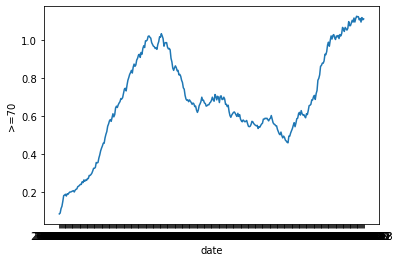

In [12]:
import seaborn as sns

sns.lineplot(x=df_UCI['date'], y=df_UCI['>=70']/df_UCI[df_UCI['date']=='2021-02-03']['>=70'].iloc[0])

In [13]:
df_UCIdf_UCI[df_UCI['date']=='2021-02-03']

,date,<=39,40-49,50-59,60-69,>=70,60 o mas,Menores de 60,Totales
308,2021-02-03,115,116,308,522,423,945,539,1484
